# Use PPO to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

03:33:25 [INFO] env: <AcrobotEnv<Acrobot-v1>>
03:33:25 [INFO] action_space: Discrete(3)
03:33:25 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
03:33:25 [INFO] reward_range: (-inf, inf)
03:33:25 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
03:33:25 [INFO] _max_episode_steps: 500
03:33:25 [INFO] _elapsed_steps: None
03:33:25 [INFO] id: Acrobot-v1
03:33:25 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
03:33:25 [INFO] reward_threshold: -100.0
03:33:25 [INFO] nondeterministic: False
03:33:25 [INFO] max_episode_steps: 500
03:33:25 [INFO] _kwargs: {}
03:33:25 [INFO] _env_name: Acrobot


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        if self.memory.empty:
            self.memory = df[self.fields]
        else:
            self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.fields)

In [4]:
class PPOAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = PPOReplayer()

        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax,
                learning_rate=0.001)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                learning_rate=0.002)

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        probs = self.actor_net.predict(observation[np.newaxis], verbose=0)[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()
                        # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'terminated', 'action'], dtype=object)
        states = np.stack(df['state'])
        df['v'] = self.critic_net.predict(states, verbose=0)
        pis = self.actor_net.predict(states, verbose=0)
        df['prob'] = [pi[action] for pi, action in zip(pis, df['action'])]
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        action_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_pi_tensor = tf.convert_to_tensor(old_pis, dtype=tf.float32)
        advantage_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)

        # update actor
        with tf.GradientTape() as tape:
            all_pi_tensor = self.actor_net(state_tensor)
            pi_tensor = tf.gather(all_pi_tensor, action_tensor, batch_dims=1)
            surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * \
                    advantage_tensor
            clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor
            max_surrogate_advantage_tensor = advantage_tensor + \
                    tf.where(advantage_tensor > 0.,
                    clip_times_advantage_tensor, -clip_times_advantage_tensor)
            clipped_surrogate_advantage_tensor = tf.minimum(
                    surrogate_advantage_tensor, max_surrogate_advantage_tensor)
            loss_tensor = -tf.reduce_mean(clipped_surrogate_advantage_tensor)
        actor_grads = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(
                zip(actor_grads, self.actor_net.variables))

        # update critic
        self.critic_net.fit(states, returns, verbose=0)


agent = PPOAgent(env)

03:33:26 [INFO] ==== train ====
03:34:14 [INFO] train episode 0: reward = -500.00, steps = 500
03:34:14 [INFO] NumExpr defaulting to 8 threads.
03:35:03 [INFO] train episode 1: reward = -500.00, steps = 500
03:35:52 [INFO] train episode 2: reward = -500.00, steps = 500
03:36:40 [INFO] train episode 3: reward = -500.00, steps = 500
03:37:27 [INFO] train episode 4: reward = -485.00, steps = 486
03:38:14 [INFO] train episode 5: reward = -500.00, steps = 500
03:38:45 [INFO] train episode 6: reward = -339.00, steps = 340
03:39:27 [INFO] train episode 7: reward = -448.00, steps = 449
03:39:54 [INFO] train episode 8: reward = -292.00, steps = 293
03:40:29 [INFO] train episode 9: reward = -383.00, steps = 384
03:41:16 [INFO] train episode 10: reward = -500.00, steps = 500
03:41:42 [INFO] train episode 11: reward = -283.00, steps = 284
03:42:05 [INFO] train episode 12: reward = -254.00, steps = 255
03:42:30 [INFO] train episode 13: reward = -267.00, steps = 268
03:43:16 [INFO] train episode 14:

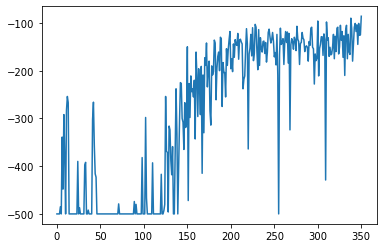

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()